In [ ]:
# 本项目使用豆粕期货从2006年1月到2025年12月的数据，分析了豆粕期货的价格走势和相关因素。
# 通过数据清洗、因子构建、信号生成，使用以crowded factor因子为入场信号，结合固定百分比take profit、trail take profit以及固定stop loss构建交易策略，并对策略表现进行了回测评估。
# 数据被区分为，2024年1月之前的数据为样本内，之后为样本外数据。
# 由样本的测试，并通过可调整的参数，试图赚取Alpha。样本外测试表明，样本外Alpha依然存在，但是已衰退。
# 该项目的代码使用了Python的pandas和Polars库进行数据处理和分析，使用torch.tensor用以网格扫描加速，并使用了matplotlib和seaborn库进行数据可视化。

In [1]:
# 需要以下一些库
# 主要库
from pathlib import Path
import numpy as np
import pandas as pd

# 做成tensor用来扫网格更快
import torch
import torch.nn as nn
import torch.optim as optim
import polars as pl

# 用来制图
import matplotlib.pyplot as plt

# 用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# 来自文件夹的所有Excel文件路径 （根据文件的路径修改）
folder = Path(r"H:\shanyi\desktop\LongTerm Strategy of Family member\Gaia learning\Quant")
file_paths = list(folder.glob("*.xlsx"))


In [3]:
# 读取所有Excel文件并合并成一个DataFrame
df_list = []

for file in file_paths:
    df_i = pd.read_excel(file, engine="openpyxl")
    df_i["source_file"] = file.name if hasattr(file, "name") else file
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
df = df.reset_index(drop=True)

df.head(10)


d:\Users\shanyi\anaconda3\envs\torch-gpu\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Users\shanyi\anaconda3\envs\torch-gpu\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Users\shanyi\anaconda3\envs\torch-gpu\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Users\shanyi\anaconda3\envs\torch-gpu\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Users\shanyi\anaconda3\envs\torch-gpu\lib

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
0,豆粕,m2401,20240102,"3,810","3,859","3,760","3,770","3,910","3,785",-140,-125,"2,052","10,928","-7,040","77,669,480",m_ftr (1).xlsx
1,豆粕,m2403,20240102,"3,748","3,748","3,667","3,667","3,812","3,691",-145,-121,"219,414","440,756","-29,042","8,099,620,120",m_ftr (1).xlsx
2,豆粕,m2405,20240102,"3,290","3,294","3,234","3,248","3,343","3,258",-95,-85,"1,769,916","2,859,210","91,254","57,669,870,160",m_ftr (1).xlsx
3,豆粕,m2407,20240102,"3,288","3,288","3,222","3,235","3,324","3,254",-89,-70,"82,092","957,180","-4,120","2,671,493,880",m_ftr (1).xlsx
4,豆粕,m2408,20240102,"3,352","3,358","3,298","3,313","3,392","3,324",-79,-68,"26,714","151,108","7,140","888,157,680",m_ftr (1).xlsx
5,豆粕,m2409,20240102,"3,345","3,345","3,283","3,300","3,369","3,308",-69,-61,"351,266","835,898","86,544","11,622,536,000",m_ftr (1).xlsx
6,豆粕,m2411,20240102,"3,311","3,316","3,262","3,276","3,344","3,285",-68,-59,"12,298","91,312",88,"404,006,660",m_ftr (1).xlsx
7,豆粕,m2412,20240102,"3,305","3,312","3,256","3,271","3,331","3,279",-60,-52,"2,922","23,466",564,"95,813,420",m_ftr (1).xlsx
8,豆粕,m2401,20240103,"3,793","3,808","3,766","3,777","3,785","3,771",-8,-14,512,"10,736",-192,"19,307,940",m_ftr (1).xlsx
9,豆粕,m2403,20240103,"3,662","3,672","3,635","3,664","3,691","3,653",-27,-38,"184,384","435,864","-4,892","6,736,585,520",m_ftr (1).xlsx


In [4]:
# 查看每个文件的行数
df.groupby("source_file").size()

source_file
m_ftr (1).xlsx     1936
m_ftr (10).xlsx    1952
m_ftr (11).xlsx    1960
m_ftr (12).xlsx    1904
m_ftr (13).xlsx    1944
m_ftr (14).xlsx    1952
m_ftr (15).xlsx    1936
m_ftr (16).xlsx    1952
m_ftr (17).xlsx    1968
m_ftr (18).xlsx    1936
m_ftr (19).xlsx    1944
m_ftr (2).xlsx     1936
m_ftr (3).xlsx     1936
m_ftr (4).xlsx     1944
m_ftr (5).xlsx     1944
m_ftr (6).xlsx     1952
m_ftr (7).xlsx     1944
m_ftr (8).xlsx     1952
m_ftr (9).xlsx     1952
m_ftr.xlsx         1880
dtype: int64

In [5]:
# 查看数据的基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38824 entries, 0 to 38823
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   商品名称         38824 non-null  object
 1   合约名称         38824 non-null  object
 2   交易日期         38824 non-null  int64 
 3   开盘价          38824 non-null  object
 4   最高价          38824 non-null  object
 5   最低价          38824 non-null  object
 6   收盘价          38824 non-null  object
 7   前结算价         38824 non-null  object
 8   结算价          38824 non-null  object
 9   涨跌           38824 non-null  int64 
 10  涨跌1          38824 non-null  int64 
 11  成交量          38824 non-null  object
 12  持仓量          38824 non-null  object
 13  持仓量变化        38824 non-null  object
 14  成交额          38824 non-null  object
 15  source_file  38824 non-null  object
dtypes: int64(3), object(13)
memory usage: 4.7+ MB


In [6]:
# 查看缺失值情况
df.isna().sum().sort_values(ascending=False).head(10)

商品名称    0
合约名称    0
交易日期    0
开盘价     0
最高价     0
最低价     0
收盘价     0
前结算价    0
结算价     0
涨跌      0
dtype: int64

In [7]:
# 查看重复值情况
df.duplicated().sum()

np.int64(0)

In [8]:
# 数据清洗
num_cols=['开盘价','最高价','最低价','收盘价','前结算价','结算价','涨跌','涨跌1','成交量','持仓量变化','成交额']
for col in num_cols:
    df[col]=df[col].astype(str).str.replace(',','')
    df[col]=pd.to_numeric(df[col], errors='coerce')
df['交易日期']=pd.to_datetime(df['交易日期'],format='%Y%m%d')
df=df.sort_values(['合约名称', '交易日期']).reset_index(drop=True)
df['持仓量']=df['持仓量'].astype(str).str.replace(',', '')
df['持仓量']=pd.to_numeric(df['持仓量'],errors='coerce')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38824 entries, 0 to 38823
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   商品名称         38824 non-null  object        
 1   合约名称         38824 non-null  object        
 2   交易日期         38824 non-null  datetime64[ns]
 3   开盘价          38824 non-null  int64         
 4   最高价          38824 non-null  int64         
 5   最低价          38824 non-null  int64         
 6   收盘价          38824 non-null  int64         
 7   前结算价         38824 non-null  int64         
 8   结算价          38824 non-null  int64         
 9   涨跌           38824 non-null  int64         
 10  涨跌1          38824 non-null  int64         
 11  成交量          38824 non-null  int64         
 12  持仓量          38824 non-null  int64         
 13  持仓量变化        38824 non-null  int64         
 14  成交额          38824 non-null  int64         
 15  source_file  38824 non-null  object        
dtypes: d

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
0,豆粕,m0601,2006-01-04,2430,2430,2350,2430,2337,2410,93,73,256,538,-146,6170000,m_ftr (19).xlsx
1,豆粕,m0601,2006-01-05,2410,2410,2390,2390,2410,2404,-20,-6,160,418,-120,3847200,m_ftr (19).xlsx
2,豆粕,m0601,2006-01-06,2381,2420,2381,2420,2404,2416,16,12,22,416,-2,531620,m_ftr (19).xlsx
3,豆粕,m0601,2006-01-09,2380,2380,2380,2380,2416,2380,-36,-36,6,416,0,142800,m_ftr (19).xlsx
4,豆粕,m0601,2006-01-10,2388,2497,2388,2497,2380,2465,117,85,14,406,-10,345220,m_ftr (19).xlsx


In [11]:
# 保存为Parquet格式
df.to_parquet("dataset.parquet", index=False)
df = pd.read_parquet("dataset.parquet")
df

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
0,豆粕,m0601,2006-01-04,2430,2430,2350,2430,2337,2410,93,73,256,538,-146,6170000,m_ftr (19).xlsx
1,豆粕,m0601,2006-01-05,2410,2410,2390,2390,2410,2404,-20,-6,160,418,-120,3847200,m_ftr (19).xlsx
2,豆粕,m0601,2006-01-06,2381,2420,2381,2420,2404,2416,16,12,22,416,-2,531620,m_ftr (19).xlsx
3,豆粕,m0601,2006-01-09,2380,2380,2380,2380,2416,2380,-36,-36,6,416,0,142800,m_ftr (19).xlsx
4,豆粕,m0601,2006-01-10,2388,2497,2388,2497,2380,2465,117,85,14,406,-10,345220,m_ftr (19).xlsx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38819,豆粕,m2612,2025-12-15,2954,2956,2880,2917,2898,2922,19,24,19456,4294,4294,568689740,m_ftr.xlsx
38820,豆粕,m2612,2025-12-16,2917,2928,2905,2920,2922,2915,-2,-7,4168,5256,962,121530040,m_ftr.xlsx
38821,豆粕,m2612,2025-12-17,2920,2930,2916,2921,2915,2923,6,8,2668,5968,712,77990120,m_ftr.xlsx
38822,豆粕,m2612,2025-12-18,2918,2924,2910,2919,2923,2917,-4,-6,2918,6806,838,85129920,m_ftr.xlsx


In [12]:
#   选择持仓量最大的合约作为主力合约
main_contract=df.loc[df.groupby('交易日期')['持仓量'].idxmax()]
main_contract=main_contract.sort_values('交易日期').reset_index(drop=True)
main_contract.head(10)

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,涨跌1,成交量,持仓量,持仓量变化,成交额,source_file
0,豆粕,m0605,2006-01-04,2380,2412,2375,2412,2320,2397,92,77,511524,258942,9984,12264442620,m_ftr (19).xlsx
1,豆粕,m0605,2006-01-05,2413,2440,2405,2434,2397,2422,37,25,743122,276336,17394,18004386420,m_ftr (19).xlsx
2,豆粕,m0605,2006-01-06,2395,2444,2386,2438,2422,2418,16,-4,705728,320930,44594,17066158760,m_ftr (19).xlsx
3,豆粕,m0605,2006-01-09,2370,2414,2365,2392,2418,2393,-26,-25,822360,326468,5538,19679164660,m_ftr (19).xlsx
4,豆粕,m0605,2006-01-10,2371,2392,2360,2389,2393,2375,-4,-18,554936,325530,-938,13180902760,m_ftr (19).xlsx
5,豆粕,m0605,2006-01-11,2375,2380,2350,2360,2375,2365,-15,-10,580826,315060,-10470,13736862600,m_ftr (19).xlsx
6,豆粕,m0605,2006-01-12,2340,2349,2326,2339,2365,2337,-26,-28,481392,315020,-40,11251094100,m_ftr (19).xlsx
7,豆粕,m0605,2006-01-13,2308,2314,2290,2310,2337,2301,-27,-36,455408,319460,4440,10482189440,m_ftr (19).xlsx
8,豆粕,m0605,2006-01-16,2319,2334,2312,2329,2301,2324,28,23,328152,326000,6540,7626571640,m_ftr (19).xlsx
9,豆粕,m0605,2006-01-17,2318,2336,2291,2294,2324,2321,-30,-3,462664,325440,-560,10741906620,m_ftr (19).xlsx


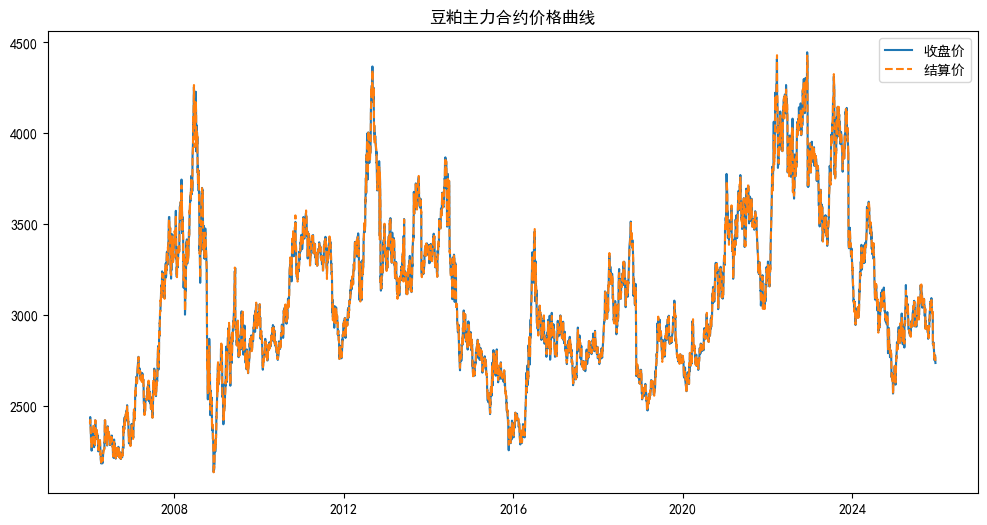

In [14]:
# 设置中文字体和负号显示

from matplotlib import rcParams

# 设置中文字体为 SimHei（黑体）
rcParams['font.sans-serif'] = ['SimHei']
# 正常显示负号
rcParams['axes.unicode_minus'] = False

#   绘制主力合约的收盘价和结算价曲线
plt.figure(figsize=(12,6))
plt.plot(main_contract['交易日期'], main_contract['收盘价'], label='收盘价')
plt.plot(main_contract['交易日期'], main_contract['结算价'], label='结算价', linestyle='--')
plt.legend()
plt.title('豆粕主力合约价格曲线')
plt.show()

In [15]:
# 收盘价收益率
main_contract['return'] = main_contract['收盘价'].pct_change()
main_contract['return'].describe()
main_contract['lnret'] = np.log(main_contract['收盘价'] / main_contract['收盘价'].shift(1))

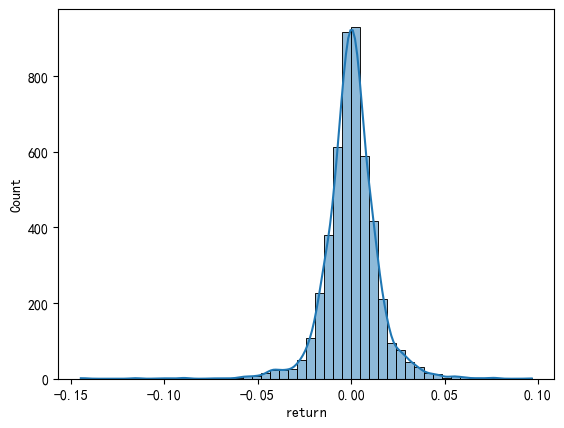

In [17]:
#   绘制主力合约的收益率分布图
import seaborn as sns
sns.histplot(main_contract['return'].dropna(), bins=50, kde=True)
plt.show()

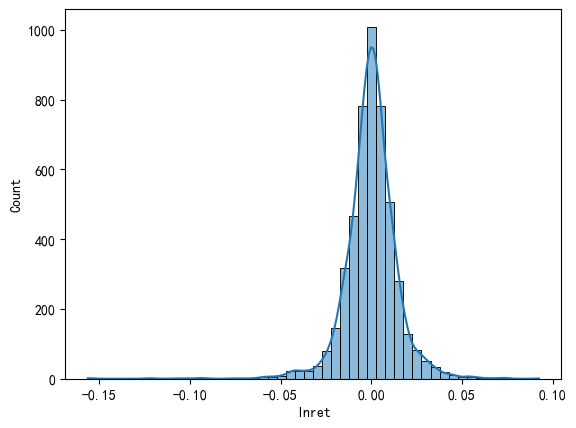

In [18]:
#   绘制主力合约的对数收益率分布图 
sns.histplot(main_contract['lnret'].dropna(), bins=50, kde=True)
plt.show()

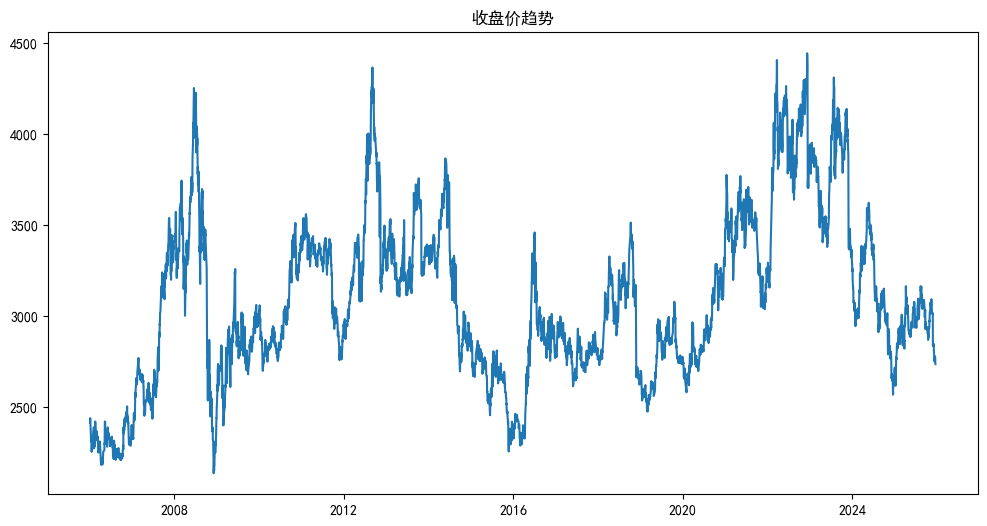

In [19]:
#   绘制主力合约的收盘价趋势图
plt.figure(figsize=(12,6))
plt.title('收盘价趋势')
plt.plot(main_contract['交易日期'], main_contract['收盘价'])
plt.show()

In [20]:
from scipy.stats import zscore

# 计算因子
def calculate_factors():

    # 五日价格涨跌
    main_contract['pct_change_5'] = main_contract['收盘价'].pct_change(5)
    main_contract.loc[:, 'pct_change_5'] = main_contract['pct_change_5'].fillna(0)

    # Calculate open interest ratio
    main_contract['open_interest_ratio'] = main_contract['持仓量'] / main_contract['成交量']
    main_contract['open_interest_ratio'] = main_contract['open_interest_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

    # ---- Standardize factors----
    main_contract['open_interest_ratio_z'] = zscore(main_contract['open_interest_ratio'].values, nan_policy='omit')
    main_contract['pct_change_5_z'] = zscore(main_contract['pct_change_5'].values, nan_policy='omit')

    # Calculate crowded factor as product of z-scores（
    main_contract['crowded_factor'] = main_contract['open_interest_ratio_z'] * main_contract['pct_change_5_z']


    
        
    return main_contract

# Apply the function to the dataframe
Factor1 = calculate_factors()

# Display results
print(Factor1.head(10))
print(Factor1.tail(10))




  商品名称   合约名称       交易日期   开盘价   最高价   最低价   收盘价  前结算价   结算价  涨跌  ...  持仓量变化  \
0   豆粕  m0605 2006-01-04  2380  2412  2375  2412  2320  2397  92  ...   9984   
1   豆粕  m0605 2006-01-05  2413  2440  2405  2434  2397  2422  37  ...  17394   
2   豆粕  m0605 2006-01-06  2395  2444  2386  2438  2422  2418  16  ...  44594   
3   豆粕  m0605 2006-01-09  2370  2414  2365  2392  2418  2393 -26  ...   5538   
4   豆粕  m0605 2006-01-10  2371  2392  2360  2389  2393  2375  -4  ...   -938   
5   豆粕  m0605 2006-01-11  2375  2380  2350  2360  2375  2365 -15  ... -10470   
6   豆粕  m0605 2006-01-12  2340  2349  2326  2339  2365  2337 -26  ...    -40   
7   豆粕  m0605 2006-01-13  2308  2314  2290  2310  2337  2301 -27  ...   4440   
8   豆粕  m0605 2006-01-16  2319  2334  2312  2329  2301  2324  28  ...   6540   
9   豆粕  m0605 2006-01-17  2318  2336  2291  2294  2324  2321 -30  ...   -560   

           成交额      source_file    return     lnret pct_change_5  \
0  12264442620  m_ftr (19).xlsx       NaN       NaN

In [21]:
# 打印因子数据的描述性统计信息
print(Factor1.describe())

                                交易日期          开盘价          最高价          最低价  \
count                           4853  4853.000000  4853.000000  4853.000000   
mean   2015-12-26 16:00:47.475788032  3086.615702  3110.518442  3062.560272   
min              2006-01-04 00:00:00  2140.000000  2188.000000  2113.000000   
25%              2010-12-28 00:00:00  2780.000000  2798.000000  2761.000000   
50%              2015-12-25 00:00:00  3015.000000  3036.000000  2992.000000   
75%              2020-12-18 00:00:00  3373.000000  3396.000000  3351.000000   
max              2025-12-19 00:00:00  4450.000000  4495.000000  4407.000000   
std                              NaN   455.409558   461.188300   449.589063   

               收盘价         前结算价          结算价           涨跌          涨跌1  \
count  4853.000000  4853.000000  4853.000000  4853.000000  4853.000000   
mean   3086.978570  3085.234494  3086.311354     1.744076     1.076860   
min    2135.000000  2134.000000  2134.000000  -232.000000  -185.00

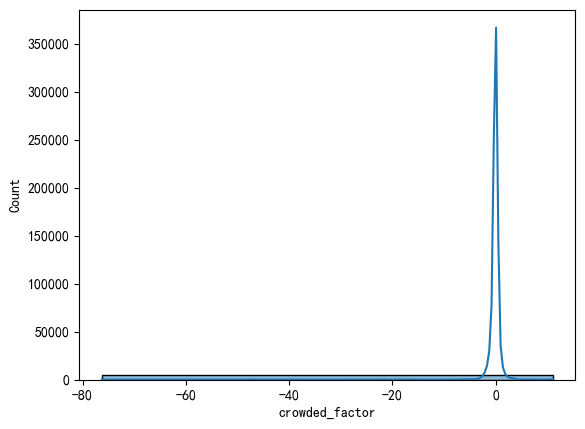

In [22]:
#   绘制主力合约的拥挤因子分布图
sns.histplot(main_contract['crowded_factor'].dropna(), bins=1, kde=True)
plt.show()

In [23]:
# 累计收益率和累计对数收益率
Factor1['cum'] = Factor1['return'].cumsum()
Factor1['lncum'] = Factor1['lnret'].cumsum()
Factor1

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,...,source_file,return,lnret,pct_change_5,open_interest_ratio,open_interest_ratio_z,pct_change_5_z,crowded_factor,cum,lncum
0,豆粕,m0605,2006-01-04,2380,2412,2375,2412,2320,2397,92,...,m_ftr (19).xlsx,NaN,NaN,0.000000,0.506217,-0.763717,-0.020157,0.015394,NaN,NaN
1,豆粕,m0605,2006-01-05,2413,2440,2405,2434,2397,2422,37,...,m_ftr (19).xlsx,0.009121,0.009080,0.000000,0.371858,-0.863207,-0.020157,0.017400,0.009121,0.009080
2,豆粕,m0605,2006-01-06,2395,2444,2386,2438,2422,2418,16,...,m_ftr (19).xlsx,0.001643,0.001642,0.000000,0.454750,-0.801827,-0.020157,0.016163,0.010764,0.010722
3,豆粕,m0605,2006-01-09,2370,2414,2365,2392,2418,2393,-26,...,m_ftr (19).xlsx,-0.018868,-0.019048,0.000000,0.396989,-0.844598,-0.020157,0.017025,-0.008103,-0.008326
4,豆粕,m0605,2006-01-10,2371,2392,2360,2389,2393,2375,-4,...,m_ftr (19).xlsx,-0.001254,-0.001255,0.000000,0.586608,-0.704190,-0.020157,0.014195,-0.009358,-0.009581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4848,豆粕,m2605,2025-12-15,2759,2772,2753,2758,2773,2762,-15,...,m_ftr.xlsx,-0.004332,-0.004342,-0.007199,2.522797,0.729509,-0.251419,-0.183413,0.642873,0.134050
4849,豆粕,m2605,2025-12-16,2763,2780,2748,2777,2762,2763,15,...,m_ftr.xlsx,0.006889,0.006865,0.005067,1.934157,0.293636,0.142605,0.041874,0.649762,0.140915
4850,豆粕,m2605,2025-12-17,2774,2784,2752,2756,2763,2766,-7,...,m_ftr.xlsx,-0.007562,-0.007591,0.000726,2.573833,0.767300,0.003170,0.002433,0.642200,0.133324
4851,豆粕,m2605,2025-12-18,2760,2760,2732,2747,2766,2745,-19,...,m_ftr.xlsx,-0.003266,-0.003271,-0.001091,2.738721,0.889395,-0.055200,-0.049094,0.638934,0.130053


In [24]:
# 打印累计收益率的描述性统计信息
print(print(Factor1[['cum']].describe()))

               cum
count  4852.000000
mean      0.507567
std       0.238162
min      -0.093876
25%       0.379229
50%       0.501698
75%       0.669378
max       1.048152
None


In [25]:
#   查看拥挤因子最高的日期及其前后10天的数据
idx = (Factor1['crowded_factor']).idxmax()
pos = Factor1.index.get_loc(idx)

print(Factor1.iloc[max(pos-10, 0) : pos+11])


     商品名称   合约名称       交易日期   开盘价   最高价   最低价   收盘价  前结算价   结算价   涨跌  ...  \
3901   豆粕  m2205 2022-01-17  3195  3205  3144  3170  3201  3173  -31  ...   
3902   豆粕  m2205 2022-01-18  3174  3176  3144  3156  3173  3161  -17  ...   
3903   豆粕  m2205 2022-01-19  3143  3183  3121  3177  3161  3153   16  ...   
3904   豆粕  m2205 2022-01-20  3184  3247  3175  3243  3153  3221   90  ...   
3905   豆粕  m2205 2022-01-21  3239  3281  3228  3270  3221  3257   49  ...   
3906   豆粕  m2205 2022-01-24  3278  3282  3244  3253  3257  3263   -4  ...   
3907   豆粕  m2205 2022-01-25  3249  3253  3207  3248  3263  3234  -15  ...   
3908   豆粕  m2205 2022-01-26  3242  3267  3235  3260  3234  3251   26  ...   
3909   豆粕  m2205 2022-01-27  3269  3379  3268  3338  3251  3323   87  ...   
3910   豆粕  m2205 2022-01-28  3358  3393  3345  3378  3323  3367   55  ...   
3911   豆粕  m2205 2022-02-07  3634  3636  3614  3636  3367  3634  269  ...   
3912   豆粕  m2205 2022-02-08  3710  3754  3683  3695  3634  3707   61  ...   

In [26]:
#   查看 abs(crowded_factor) >= 1.5 的行及其前后5行的数据
mask = Factor1['crowded_factor'].abs() >= 1.5
hit_pos = np.where(mask.to_numpy())[0]   # 所有命中的行号（整数位置）

if len(hit_pos) == 0:
    print("没有任何 abs(crowded_factor) >= 1.5 的行")
else:
    n = len(Factor1)
    # 对每个命中位置，扩展上下 5 行
    expanded_pos = np.unique(
        np.concatenate([
            np.arange(max(p-5, 0), min(p+6, n))
            for p in hit_pos
        ])
    )

    result = Factor1.iloc[expanded_pos]
    print(result)


     商品名称   合约名称       交易日期   开盘价   最高价   最低价   收盘价  前结算价   结算价  涨跌  ...  \
19     豆粕  m0605 2006-02-07  2360  2387  2345  2369  2403  2366 -34  ...   
20     豆粕  m0605 2006-02-08  2320  2320  2272  2272  2366  2287 -94  ...   
21     豆粕  m0605 2006-02-09  2301  2303  2272  2275  2287  2285 -12  ...   
22     豆粕  m0605 2006-02-10  2310  2315  2251  2290  2285  2281   5  ...   
23     豆粕  m0605 2006-02-13  2300  2300  2270  2286  2281  2282   5  ...   
...   ...    ...        ...   ...   ...   ...   ...   ...   ...  ..  ...   
4841   豆粕  m2605 2025-12-04  2844  2846  2812  2833  2842  2831  -9  ...   
4842   豆粕  m2605 2025-12-05  2835  2844  2820  2821  2831  2828 -10  ...   
4843   豆粕  m2605 2025-12-08  2821  2826  2770  2778  2828  2793 -50  ...   
4844   豆粕  m2605 2025-12-09  2781  2790  2754  2763  2793  2771 -30  ...   
4845   豆粕  m2605 2025-12-10  2755  2761  2736  2754  2771  2750 -17  ...   

          source_file    return     lnret  pct_change_5  open_interest_ratio  \
19    m

In [27]:
#   查看因子数据的列名
print(Factor1.columns)

Index(['商品名称', '合约名称', '交易日期', '开盘价', '最高价', '最低价', '收盘价', '前结算价', '结算价', '涨跌',
       '涨跌1', '成交量', '持仓量', '持仓量变化', '成交额', 'source_file', 'return', 'lnret',
       'pct_change_5', 'open_interest_ratio', 'open_interest_ratio_z',
       'pct_change_5_z', 'crowded_factor', 'cum', 'lncum'],
      dtype='object')


将绘图的因子列： ['return', 'lnret', 'pct_change_5', 'open_interest_ratio', 'open_interest_ratio_z', 'pct_change_5_z', 'crowded_factor']


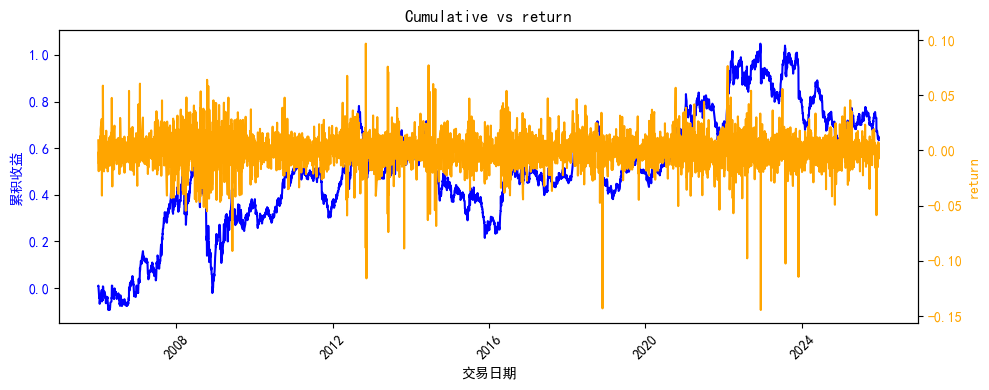

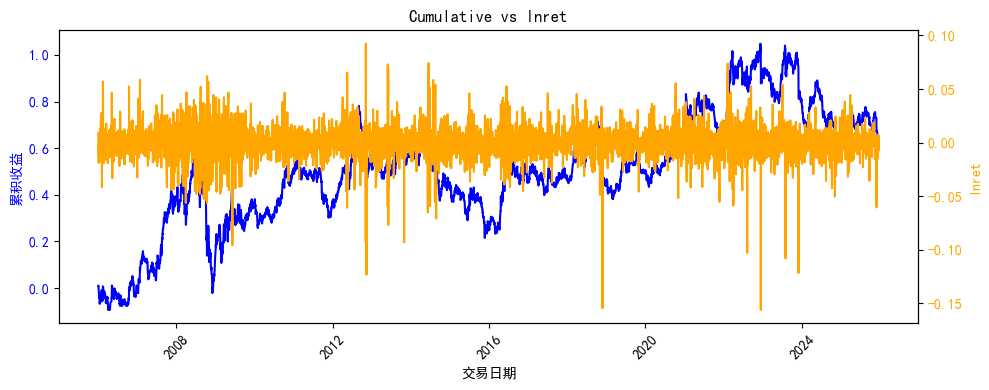

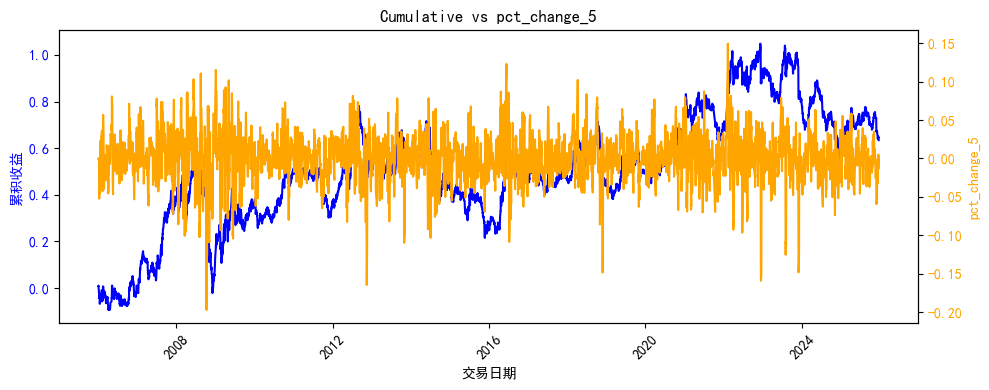

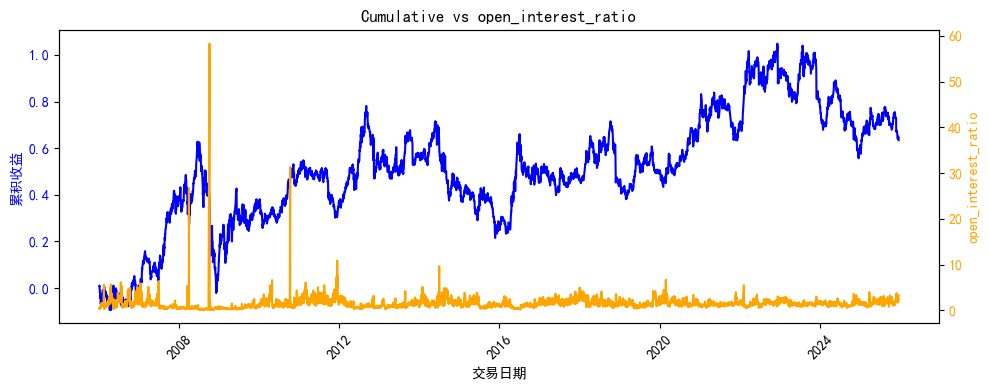

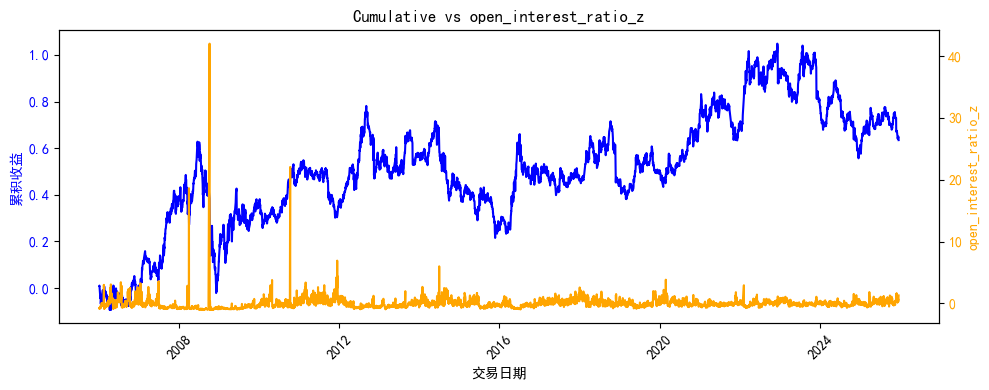

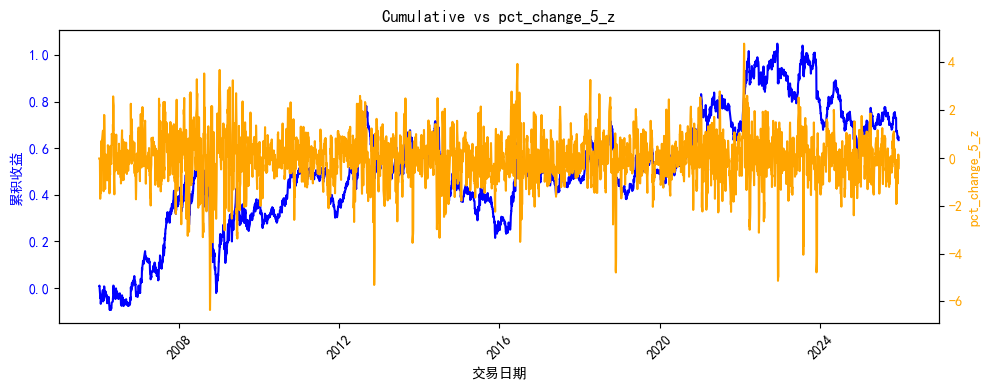

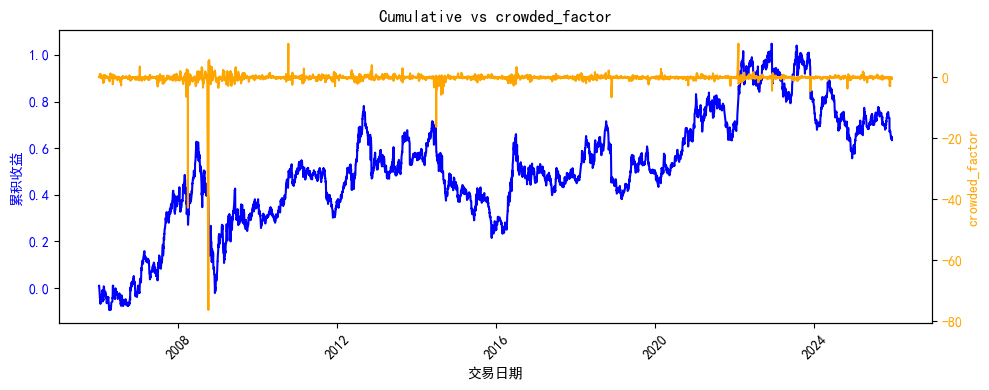

In [28]:
#   将绘图的因子列：从第16列到倒数第2列（不包括最后两列cum和lncum）
factors = list(Factor1.columns[16:-2])
print("将绘图的因子列：", factors)

# 循环画图，每个因子一张图，左 y 轴 cum，右 y 轴 factor
for factor in factors:
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # 左 y 轴：cum
    ax1.plot(Factor1['交易日期'], Factor1['cum'], color='blue', label='Cumulative')
    ax1.set_xlabel("交易日期")
    ax1.set_ylabel("累积收益", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.tick_params(axis='x', rotation=45)

    # 右 y 轴：当前因子
    ax2 = ax1.twinx()
    ax2.plot(Factor1['交易日期'], Factor1[factor], color='orange', label=factor)
    ax2.set_ylabel(factor, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title(f"Cumulative vs {factor}")
    fig.tight_layout()
    plt.show()


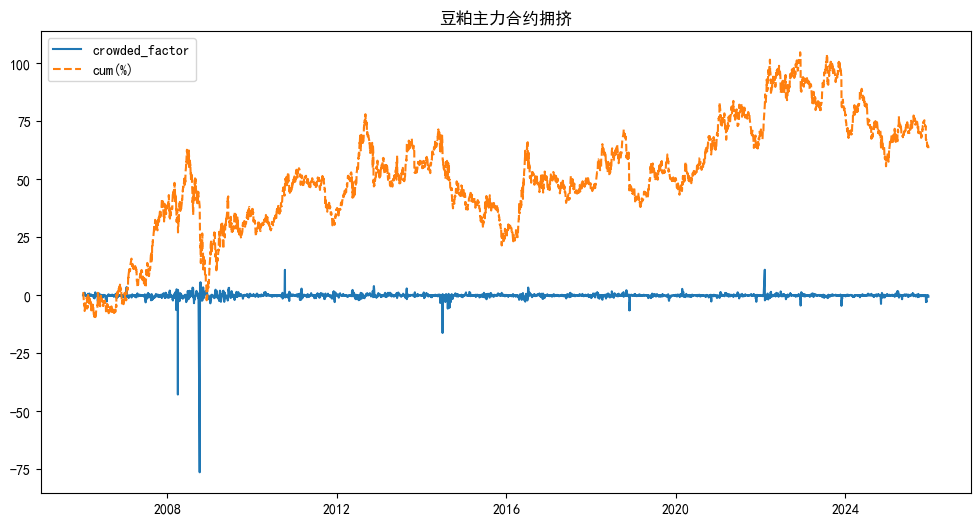

In [ ]:

# 设置中文字体为 SimHei（黑体）
rcParams['font.sans-serif'] = ['SimHei']
# 正常显示负号

rcParams['axes.unicode_minus'] = False

Factor1['cum']=Factor1['return'].cumsum()
# 绘制主力合约的拥挤因子和累计收益率曲线

plt.figure(figsize=(12,6))
plt.plot(Factor1['交易日期'], Factor1['crowded_factor'], label='crowded_factor')
plt.plot(Factor1['交易日期'], Factor1['cum']*100, label='cum(%)', linestyle='--')
plt.legend()
plt.title('豆粕主力合约拥挤')
plt.show()

In [30]:
Factor1

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,...,source_file,return,lnret,pct_change_5,open_interest_ratio,open_interest_ratio_z,pct_change_5_z,crowded_factor,cum,lncum
0,豆粕,m0605,2006-01-04,2380,2412,2375,2412,2320,2397,92,...,m_ftr (19).xlsx,NaN,NaN,0.000000,0.506217,-0.763717,-0.020157,0.015394,NaN,NaN
1,豆粕,m0605,2006-01-05,2413,2440,2405,2434,2397,2422,37,...,m_ftr (19).xlsx,0.009121,0.009080,0.000000,0.371858,-0.863207,-0.020157,0.017400,0.009121,0.009080
2,豆粕,m0605,2006-01-06,2395,2444,2386,2438,2422,2418,16,...,m_ftr (19).xlsx,0.001643,0.001642,0.000000,0.454750,-0.801827,-0.020157,0.016163,0.010764,0.010722
3,豆粕,m0605,2006-01-09,2370,2414,2365,2392,2418,2393,-26,...,m_ftr (19).xlsx,-0.018868,-0.019048,0.000000,0.396989,-0.844598,-0.020157,0.017025,-0.008103,-0.008326
4,豆粕,m0605,2006-01-10,2371,2392,2360,2389,2393,2375,-4,...,m_ftr (19).xlsx,-0.001254,-0.001255,0.000000,0.586608,-0.704190,-0.020157,0.014195,-0.009358,-0.009581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4848,豆粕,m2605,2025-12-15,2759,2772,2753,2758,2773,2762,-15,...,m_ftr.xlsx,-0.004332,-0.004342,-0.007199,2.522797,0.729509,-0.251419,-0.183413,0.642873,0.134050
4849,豆粕,m2605,2025-12-16,2763,2780,2748,2777,2762,2763,15,...,m_ftr.xlsx,0.006889,0.006865,0.005067,1.934157,0.293636,0.142605,0.041874,0.649762,0.140915
4850,豆粕,m2605,2025-12-17,2774,2784,2752,2756,2763,2766,-7,...,m_ftr.xlsx,-0.007562,-0.007591,0.000726,2.573833,0.767300,0.003170,0.002433,0.642200,0.133324
4851,豆粕,m2605,2025-12-18,2760,2760,2732,2747,2766,2745,-19,...,m_ftr.xlsx,-0.003266,-0.003271,-0.001091,2.738721,0.889395,-0.055200,-0.049094,0.638934,0.130053


In [33]:
Factor2=Factor1
Factor2

,商品名称,合约名称,交易日期,开盘价,最高价,最低价,收盘价,前结算价,结算价,涨跌,...,source_file,return,lnret,pct_change_5,open_interest_ratio,open_interest_ratio_z,pct_change_5_z,crowded_factor,cum,lncum
0,豆粕,m0605,2006-01-04,2380,2412,2375,2412,2320,2397,92,...,m_ftr (19).xlsx,NaN,NaN,0.000000,0.506217,-0.763717,-0.020157,0.015394,NaN,NaN
1,豆粕,m0605,2006-01-05,2413,2440,2405,2434,2397,2422,37,...,m_ftr (19).xlsx,0.009121,0.009080,0.000000,0.371858,-0.863207,-0.020157,0.017400,0.009121,0.009080
2,豆粕,m0605,2006-01-06,2395,2444,2386,2438,2422,2418,16,...,m_ftr (19).xlsx,0.001643,0.001642,0.000000,0.454750,-0.801827,-0.020157,0.016163,0.010764,0.010722
3,豆粕,m0605,2006-01-09,2370,2414,2365,2392,2418,2393,-26,...,m_ftr (19).xlsx,-0.018868,-0.019048,0.000000,0.396989,-0.844598,-0.020157,0.017025,-0.008103,-0.008326
4,豆粕,m0605,2006-01-10,2371,2392,2360,2389,2393,2375,-4,...,m_ftr (19).xlsx,-0.001254,-0.001255,0.000000,0.586608,-0.704190,-0.020157,0.014195,-0.009358,-0.009581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4848,豆粕,m2605,2025-12-15,2759,2772,2753,2758,2773,2762,-15,...,m_ftr.xlsx,-0.004332,-0.004342,-0.007199,2.522797,0.729509,-0.251419,-0.183413,0.642873,0.134050
4849,豆粕,m2605,2025-12-16,2763,2780,2748,2777,2762,2763,15,...,m_ftr.xlsx,0.006889,0.006865,0.005067,1.934157,0.293636,0.142605,0.041874,0.649762,0.140915
4850,豆粕,m2605,2025-12-17,2774,2784,2752,2756,2763,2766,-7,...,m_ftr.xlsx,-0.007562,-0.007591,0.000726,2.573833,0.767300,0.003170,0.002433,0.642200,0.133324
4851,豆粕,m2605,2025-12-18,2760,2760,2732,2747,2766,2745,-19,...,m_ftr.xlsx,-0.003266,-0.003271,-0.001091,2.738721,0.889395,-0.055200,-0.049094,0.638934,0.130053


In [34]:
# =========================================================
# EVENT-DRIVEN  — FULL SCRIPT
# ---------------------------------------------------------
# 目标：crowded_factor 的“事件”触发 -> 次日开盘进场（无未来函数）
#      日线OHLC触发止损/止盈（SL优先），支持两种TP：
#      1) 固定TP (tp_fixed, 按价格百分比)
#      2) 回吐止盈LOCK（activate_tp + lock_tp，按价格百分比）
#      + Nbar 退出
#      + 移仓换月：合约名称变更时强制平仓->开仓（按前一日收盘结算并扣双边手续费）
#
# 备注：
# - 止损按“价格距离”来触发
#   1R_price_dist = entry * margin_ratio * stop_loss_margin_pct
#   对于 M：margin_ratio=0.07, stop_loss_margin_pct=0.02 => 0.14% 价格距离
# - 信号用当日收盘后的 crowded_factor，交易在“次日开盘”，避免未来函数
# =========================================================


# =========================
# 0) GLOBAL PARAMS
# =========================
init_capital = 1_000_000.0
contract_multiplier = 10.0
fee_per_lot = 1.5

exchange_margin_ratio = 0.09          # 保证金率
stop_loss_margin_pct = 0.02           # 止损：保证金的2%（每手）
risk_pct = 0.02                       # 资金风险预算（用于手数 sizing）

MAX_LOTS = 50
MAX_MARGIN_USAGE = 0.30               # 最大保证金占用比例

split_ts_default = "2024-01-01"
TOPK = 20
min_trades_in_sample = 5
MAX_TRADES_IS = 100000

REQUIRED_COLS = ["交易日期","合约名称","开盘价","最高价","最低价","收盘价","crowded_factor"]

# =========================
# 1) GRID 
# =========================
# 阈值：abs(cf) 的分位数 -> t
Q_LEVELS = np.round(np.arange(0.00, 1.00, 0.01, dtype=float), 2)  # 0.00..0.99

# Nbar：1..20
NBAR_GRID = np.arange(1, 21, 1, dtype=int)

# 固定TP（价格百分比）：例如 0.06 = +6%
TP_FIXED_GRID = np.arange(0.04, 0.30 + 1e-12, 0.01, dtype=float)  # 4%..30% step2%

# 回吐止盈（价格百分比）
ACTIVATE_TP_GRID = np.arange(0.08, 0.30 + 1e-12, 0.01, dtype=float)  # 8%..30% step2%
LOCK_TP_GRID     = np.arange(0.02, 0.16 + 1e-12, 0.01, dtype=float)  # 2%..16% step1%  (must < activate)

# =========================
# 2) UTIL
# =========================
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in REQUIRED_COLS:
        if c not in df.columns:
            raise ValueError(f"缺列: {c}")
    df["交易日期"] = pd.to_datetime(df["交易日期"])
    df = df.sort_values("交易日期").reset_index(drop=True)
    df["contract_id"], _ = pd.factorize(df["合约名称"], sort=False)
    return df

def annualized_cagr(nav: pd.Series):
    nav = nav.dropna()
    if len(nav) < 2:
        return np.nan, np.nan
    start = float(nav.iloc[0])
    end   = float(nav.iloc[-1])
    d0 = pd.to_datetime(nav.index[0])
    d1 = pd.to_datetime(nav.index[-1])
    years = (d1 - d0).days / 365.25
    if years <= 0 or start <= 0:
        return np.nan, years
    return (end/start)**(1.0/years)-1.0, years

# build grid: 两种 tp_mode: fixed / trail
def build_param_grid(abs_cf: np.ndarray) -> pd.DataFrame:
    qt = []
    for q in Q_LEVELS:
        q = float(np.round(q, 2))
        t = float(np.quantile(abs_cf, q))
        qt.append((q, t))

    rows = []
    # fixed
    for q, t in qt:
        for N in NBAR_GRID:
            for tp in TP_FIXED_GRID:
                rows.append({
                    "tp_mode":"fixed","q":q,"t":t,"N":int(N),
                    "tp_fixed":float(tp),"activate_tp":np.nan,"lock_tp":np.nan
                })

    # trail (activate/lock, lock < activate)
    for q, t in qt:
        for N in NBAR_GRID:
            for act in ACTIVATE_TP_GRID:
                for lock in LOCK_TP_GRID[LOCK_TP_GRID < act]:
                    rows.append({
                        "tp_mode":"trail","q":q,"t":t,"N":int(N),
                        "tp_fixed":np.nan,"activate_tp":float(act),"lock_tp":float(lock)
                    })

    return pd.DataFrame(rows)

# =========================
# 3) TORCH GRID BACKTEST (IS) — PCT TP VERSION
# =========================
@torch.no_grad()
def torch_grid_backtest_pct(
    o,h,l,c,cf,cid,
    t_vec, N_vec,
    mode_vec,          # 0 fixed, 1 trail
    tp_fixed_vec,      # pct
    act_vec, lock_vec  # pct
):
    device = o.device
    T = o.shape[0]
    P = t_vec.shape[0]

    cash = torch.full((P,), init_capital, dtype=torch.float32, device=device)
    pos_dir = torch.zeros((P,), dtype=torch.int8, device=device)     # +1 long / -1 short / 0 flat
    lots = torch.zeros((P,), dtype=torch.int32, device=device)
    entry = torch.zeros((P,), dtype=torch.float32, device=device)
    last  = torch.zeros((P,), dtype=torch.float32, device=device)

    peak   = torch.full((P,), -1e9, dtype=torch.float32, device=device)  # long peak
    trough = torch.full((P,),  1e9, dtype=torch.float32, device=device)  # short trough
    ncnt = torch.zeros((P,), dtype=torch.int32, device=device)

    trades = torch.zeros((P,), dtype=torch.int32, device=device)
    max_nav = cash.clone()
    max_dd = torch.zeros((P,), dtype=torch.float32, device=device)

    sig_prev = torch.zeros((P,), dtype=torch.int8, device=device)    # yesterday close signal -> today open

    cm  = torch.tensor(contract_multiplier, dtype=torch.float32, device=device)
    fee = torch.tensor(fee_per_lot, dtype=torch.float32, device=device)
    mrg = torch.tensor(exchange_margin_ratio, dtype=torch.float32, device=device)
    slm = torch.tensor(stop_loss_margin_pct, dtype=torch.float32, device=device)
    rkp = torch.tensor(risk_pct, dtype=torch.float32, device=device)
    max_lots_const = torch.tensor(MAX_LOTS, dtype=torch.int32, device=device)
    max_mrg_usage = torch.tensor(MAX_MARGIN_USAGE, dtype=torch.float32, device=device)
    ONE  = torch.tensor( 1, dtype=torch.int8, device=device)
    MONE = torch.tensor(-1, dtype=torch.int8, device=device)
    sig_today = torch.zeros((P,), dtype=torch.int8, device=device)

    for i in range(T):
        # -------- rollover (contract change) --------
        if i > 0:
            rollover = (pos_dir != 0) & (cid[i] != cid[i-1])
            if rollover.any():
                # 1) 平旧仓：按昨收结算 + 扣平仓手续费
                pnl_close = (c[i-1] - last) * pos_dir.float() * lots.float() * cm
                cash[rollover] += pnl_close[rollover]
                last[rollover] = c[i-1]
                cash[rollover] -= fee * lots[rollover].float()  # close fee
        
                # 2) 计算今开能开多少手（沿用原方向）
                ent = o[i]
                margin_per_lot = ent * cm * mrg
                loss_per_lot   = margin_per_lot * slm
        
                # 只对 rollover 的策略算 sizing，其它置 0
                risk_cash = torch.where(rollover, cash * rkp, torch.zeros_like(cash))
                lots_risk = torch.floor(risk_cash / (loss_per_lot + 1e-9)).to(torch.int32)
        
                lots_cash = torch.where(
                    rollover,
                    torch.floor(cash / (margin_per_lot + fee + 1e-9)).to(torch.int32),
                    torch.zeros_like(lots)
                )
        
                lots_new = torch.minimum(lots_risk, lots_cash)
                lots_new = torch.minimum(lots_new, max_lots_const)
                lots_new = torch.minimum(
                    lots_new,
                    torch.floor((cash * max_mrg_usage) / (margin_per_lot + 1e-9)).to(torch.int32)
                )
        
                ok_roll  = rollover & (lots_new > 0)
                bad_roll = rollover & (~ok_roll)
                old_dir = pos_dir.clone()
        
                # 3) bad_roll：平仓后保持空仓（状态清干净）
                if bad_roll.any():
                    pos_dir[bad_roll] = 0
                    lots[bad_roll]    = 0
                    entry[bad_roll]   = 0
                    last[bad_roll]    = 0
                    peak[bad_roll]    = -1e9
                    trough[bad_roll]  = 1e9
                    ncnt[bad_roll]    = 0
        
                # 4) ok_roll：按今开开新仓 + 扣开仓手续费（按 lots_new 扣）
               
                
                if ok_roll.any():
                    pos_dir[ok_roll] = old_dir[ok_roll]
                    lots[ok_roll]  = lots_new[ok_roll]
                    entry[ok_roll] = o[i]
                    last[ok_roll]  = o[i]
                    cash[ok_roll] -= fee * lots_new[ok_roll].float()  # open fee
        
                    # 重置跟踪变量
                    peak[ok_roll]   = h[i]
                    trough[ok_roll] = l[i]
                    ncnt[ok_roll]   = 0



        # -------- entry @ open using prev-day signal (NO FUTURE FUNC) --------
        can_open = (pos_dir == 0) & (sig_prev != 0)
        if can_open.any():
            ent = o[i]
            margin_per_lot = ent * cm * mrg
            loss_per_lot   = margin_per_lot * slm  # cash loss per lot if hit SL

            risk_cash = cash * rkp
            lots_risk = torch.floor(risk_cash / (loss_per_lot + 1e-9)).to(torch.int32)
            lots_cash = torch.floor(cash / (margin_per_lot + fee + 1e-9)).to(torch.int32)

            lots_new = torch.minimum(lots_risk, lots_cash)
            lots_new = torch.minimum(lots_new, max_lots_const)
            lots_new = torch.minimum(
                lots_new,
                torch.floor((cash * max_mrg_usage) / (margin_per_lot + 1e-9)).to(torch.int32)
            )

            ok = can_open & (lots_new > 0)
            if ok.any():
                pos_dir[ok] = sig_prev[ok]
                lots[ok] = lots_new[ok]
                entry[ok] = ent
                last[ok]  = ent
                cash[ok] -= fee * lots_new[ok].float()
                peak[ok] = h[i]
                trough[ok] = l[i]
                ncnt[ok] = 0

        # -------- intraday exits (SL priority) --------
        holding = (pos_dir != 0)
        if holding.any():
            ent = entry
            las = last

            # SL (price dist from margin-based SL)
            dist_price = ent * mrg * slm

            # ===== LONG =====
            is_long = holding & (pos_dir == 1)
            if is_long.any():
                sl_price = ent - dist_price

                fixed = is_long & (mode_vec == 0)
                if fixed.any():
                    tp_price = ent * (1.0 + tp_fixed_vec)
                    hit_sl = l[i] <= sl_price
                    hit_tp = h[i] >= tp_price

                    exit_sl = fixed & hit_sl
                    if exit_sl.any():
                        pnl = (sl_price - las) * lots.float() * cm
                        cash[exit_sl] += pnl[exit_sl]
                        cash[exit_sl] -= fee * lots[exit_sl].float()
                        pos_dir[exit_sl]=0; lots[exit_sl]=0; entry[exit_sl]=0; last[exit_sl]=0
                        peak[exit_sl]=-1e9; trough[exit_sl]=1e9; ncnt[exit_sl]=0
                        trades[exit_sl]+=1

                    still = fixed & (pos_dir == 1)
                    exit_tp = still & (~hit_sl) & hit_tp
                    if exit_tp.any():
                        pnl = (tp_price - las) * lots.float() * cm
                        cash[exit_tp] += pnl[exit_tp]
                        cash[exit_tp] -= fee * lots[exit_tp].float()
                        pos_dir[exit_tp]=0; lots[exit_tp]=0; entry[exit_tp]=0; last[exit_tp]=0
                        peak[exit_tp]=-1e9; trough[exit_tp]=1e9; ncnt[exit_tp]=0
                        trades[exit_tp]+=1

                trail = is_long & (mode_vec == 1) & (pos_dir == 1)
                if trail.any():
                    peak_now = torch.maximum(peak, h[i])  # 包含当天最高价


                    act_level = ent * (1.0 + act_vec)
                    activated = trail & (peak_now >= act_level)

                    if activated.any():
                        lock_price = peak_now * (1.0 - lock_vec)
                        hit_sl = l[i] <= sl_price
                        hit_lock = l[i] <= lock_price

                        exit_sl = activated & hit_sl
                        if exit_sl.any():
                            pnl = (sl_price - las) * lots.float() * cm
                            cash[exit_sl] += pnl[exit_sl]
                            cash[exit_sl] -= fee * lots[exit_sl].float()
                            pos_dir[exit_sl]=0; lots[exit_sl]=0; entry[exit_sl]=0; last[exit_sl]=0
                            peak[exit_sl]=-1e9; trough[exit_sl]=1e9; ncnt[exit_sl]=0
                            trades[exit_sl]+=1

                        still_a = activated & (pos_dir == 1)
                        exit_lock = still_a & (~hit_sl) & hit_lock
                        if exit_lock.any():
                            pnl = (lock_price - las) * lots.float() * cm
                            cash[exit_lock] += pnl[exit_lock]
                            cash[exit_lock] -= fee * lots[exit_lock].float()
                            pos_dir[exit_lock]=0; lots[exit_lock]=0; entry[exit_lock]=0; last[exit_lock]=0
                            peak[exit_lock]=-1e9; trough[exit_lock]=1e9; ncnt[exit_lock]=0
                            trades[exit_lock]+=1
                    

                    not_act = trail & (peak_now < act_level)
                    if not_act.any():
                        hit_sl = l[i] <= sl_price
                        exit_sl = not_act & hit_sl
                        if exit_sl.any():
                            pnl = (sl_price - las) * lots.float() * cm
                            cash[exit_sl] += pnl[exit_sl]
                            cash[exit_sl] -= fee * lots[exit_sl].float()
                            pos_dir[exit_sl]=0; lots[exit_sl]=0; entry[exit_sl]=0; last[exit_sl]=0
                            peak[exit_sl]=-1e9; trough[exit_sl]=1e9; ncnt[exit_sl]=0
                            trades[exit_sl]+=1
            # ===== SHORT =====
            holding = (pos_dir != 0)
            is_short = holding & (pos_dir == -1)
            if is_short.any():
                sl_price = ent + dist_price

                fixed = is_short & (mode_vec == 0)
                if fixed.any():
                    tp_price = ent * (1.0 - tp_fixed_vec)
                    hit_sl = h[i] >= sl_price
                    hit_tp = l[i] <= tp_price

                    exit_sl = fixed & hit_sl
                    if exit_sl.any():
                        pnl = (sl_price - las) * pos_dir.float() * lots.float() * cm
                        cash[exit_sl] += pnl[exit_sl]
                        cash[exit_sl] -= fee * lots[exit_sl].float()
                        pos_dir[exit_sl]=0; lots[exit_sl]=0; entry[exit_sl]=0; last[exit_sl]=0
                        peak[exit_sl]=-1e9; trough[exit_sl]=1e9; ncnt[exit_sl]=0
                        trades[exit_sl]+=1

                    still = fixed & (pos_dir == -1)
                    exit_tp = still & (~hit_sl) & hit_tp
                    if exit_tp.any():
                        pnl = (tp_price - las) * pos_dir.float() * lots.float() * cm
                        cash[exit_tp] += pnl[exit_tp]
                        cash[exit_tp] -= fee * lots[exit_tp].float()
                        pos_dir[exit_tp]=0; lots[exit_tp]=0; entry[exit_tp]=0; last[exit_tp]=0
                        peak[exit_tp]=-1e9; trough[exit_tp]=1e9; ncnt[exit_tp]=0
                        trades[exit_tp]+=1

                trail = is_short & (mode_vec == 1) & (pos_dir == -1)
                if trail.any():
                    trough_now = torch.minimum(trough, l[i])  # 包含当天最低价


                    act_level = ent * (1.0 - act_vec)
                    activated = trail & (trough_now <= act_level)

                    if activated.any():
                        lock_price = trough_now * (1.0 + lock_vec)
                        hit_sl = h[i] >= sl_price
                        hit_lock = h[i] >= lock_price

                        exit_sl = activated & hit_sl
                        if exit_sl.any():
                            pnl = (sl_price - las) * pos_dir.float() * lots.float() * cm
                            cash[exit_sl] += pnl[exit_sl]
                            cash[exit_sl] -= fee * lots[exit_sl].float()
                            pos_dir[exit_sl]=0; lots[exit_sl]=0; entry[exit_sl]=0; last[exit_sl]=0
                            peak[exit_sl]=-1e9; trough[exit_sl]=1e9; ncnt[exit_sl]=0
                            trades[exit_sl]+=1

                        still_a = activated & (pos_dir == -1)
                        exit_lock = still_a & (~hit_sl) & hit_lock
                        if exit_lock.any():
                            pnl = (lock_price - las) * pos_dir.float() * lots.float() * cm
                            cash[exit_lock] += pnl[exit_lock]
                            cash[exit_lock] -= fee * lots[exit_lock].float()
                            pos_dir[exit_lock]=0; lots[exit_lock]=0; entry[exit_lock]=0; last[exit_lock]=0
                            peak[exit_lock]=-1e9; trough[exit_lock]=1e9; ncnt[exit_lock]=0
                            trades[exit_lock]+=1

                    not_act = trail & (trough_now > act_level)
                    if not_act.any():
                        hit_sl = h[i] >= sl_price
                        exit_sl = not_act & hit_sl
                        if exit_sl.any():
                            pnl = (sl_price - las) * pos_dir.float() * lots.float() * cm
                            cash[exit_sl] += pnl[exit_sl]
                            cash[exit_sl] -= fee * lots[exit_sl].float()
                            pos_dir[exit_sl]=0; lots[exit_sl]=0; entry[exit_sl]=0; last[exit_sl]=0
                            peak[exit_sl]=-1e9; trough[exit_sl]=1e9; ncnt[exit_sl]=0
                            trades[exit_sl]+=1

            # -------- EOD MTM + peak/trough update + NBAR exit --------
            holding = (pos_dir != 0)
            if holding.any():
                pnl = (c[i] - last) * pos_dir.float() * lots.float() * cm
                cash[holding] += pnl[holding]
                last[holding] = c[i]
    
                long_h = holding & (pos_dir == 1)
                short_h = holding & (pos_dir == -1)
    
                # 只在多头持仓上更新 peak 和 ncnt
                if long_h.any():
                    new_high = long_h & (h[i] > peak)
                    peak = torch.where(new_high, h[i], peak)
                    ncnt = torch.where(long_h, torch.where(new_high, torch.zeros_like(ncnt), ncnt + 1), ncnt)
    
                # 只在空头持仓上更新 trough 和 ncnt
                if short_h.any():
                    new_low = short_h & (l[i] < trough)
                    trough = torch.where(new_low, l[i], trough)
                    ncnt = torch.where(short_h, torch.where(new_low, torch.zeros_like(ncnt), ncnt + 1), ncnt)
    
                # 平仓后把 ncnt 清干净（防脏状态）
                ncnt = torch.where(pos_dir == 0, torch.zeros_like(ncnt), ncnt)
    
                exit_n = holding & (ncnt >= N_vec)
                if exit_n.any():
                    cash[exit_n] -= fee * lots[exit_n].float()
                    pos_dir[exit_n]=0; lots[exit_n]=0; entry[exit_n]=0; last[exit_n]=0
                    peak[exit_n]=-1e9; trough[exit_n]=1e9; ncnt[exit_n]=0
                    trades[exit_n]+=1

        # -------- drawdown --------
        max_nav = torch.maximum(max_nav, cash)
        dd = cash / (max_nav + 1e-9) - 1.0
        max_dd = torch.minimum(max_dd, dd)

        # -------- signal at close -> trade next open --------
            # cf > +t => 认为多头拥挤 => 次日做空
            # cf < -t => 认为空头拥挤 => 次日做多
        sig_today = torch.zeros_like(sig_prev)
        sig_today = torch.where(cf[i] > t_vec, ONE,  sig_today)
        sig_today = torch.where(cf[i] < -t_vec, MONE, sig_today)
        sig_prev = sig_today


    # end liquidation
    holding = (pos_dir != 0)
    if holding.any():
        pnl = (c[-1] - last) * pos_dir.float() * lots.float() * cm
        cash[holding] += pnl[holding]
        cash[holding] -= fee * lots[holding].float()
        trades[holding] += 1

    return cash, max_dd, trades

# =========================
# 4) SINGLE CURVE BACKTEST (for plotting IS/OOS)
# =========================
def backtest_one_curve_pct(df: pd.DataFrame, p: dict):
    o = df["开盘价"].to_numpy(np.float64)
    h = df["最高价"].to_numpy(np.float64)
    l = df["最低价"].to_numpy(np.float64)
    c = df["收盘价"].to_numpy(np.float64)
    cf= df["crowded_factor"].to_numpy(np.float64)
    cid=df["contract_id"].to_numpy(np.int64)
    dates = pd.to_datetime(df["交易日期"].to_numpy())

    t = float(p["t"]); N = int(p["N"]); mode = p["tp_mode"]
    tp_fixed = float(p["tp_fixed"]) if mode=="fixed" else None
    act = float(p["activate_tp"]) if mode=="trail" else None
    lock = float(p["lock_tp"]) if mode=="trail" else None

    def signal(x):
        if x >  t: return 1
        if x < -t: return -1
        return 0

    def size(cash_now, entry_price):
        margin_per_lot = entry_price * contract_multiplier * exchange_margin_ratio
        loss_per_lot   = margin_per_lot * stop_loss_margin_pct
        risk_cash = cash_now * risk_pct
        lots_risk = int(np.floor(risk_cash / (loss_per_lot + 1e-12)))
        lots_cash = int(np.floor(cash_now / (margin_per_lot + fee_per_lot + 1e-12)))
        lots_new = min(lots_risk, lots_cash, MAX_LOTS,
                       int(np.floor((cash_now * MAX_MARGIN_USAGE) / (margin_per_lot + 1e-12))))
        return max(lots_new, 0)

    cash = init_capital
    pos = 0
    lots = 0
    entry = 0.0
    last  = 0.0
    peak = -1e18
    trough = 1e18
    ncnt = 0
    trades = 0
    max_nav = init_capital
    max_dd = 0.0

    sig_prev = 0
    nav = np.empty(len(df), dtype=np.float64)

    for i in range(len(df)):
        # rollover
        if i > 0 and pos != 0 and cid[i] != cid[i-1]:
            # 1) 平旧仓：按昨收结算 + 扣平仓手续费
            cash += (c[i-1] - last) * pos * lots * contract_multiplier
            last = c[i-1]
            cash -= fee_per_lot * lots  # close fee
        
            # 2) 计算今开能否开新仓（沿用原方向）
            lots_new = size(cash, o[i])
        
            if lots_new <= 0:
                # bad_roll：平仓后空仓
                pos = 0; lots = 0; entry = 0.0; last = 0.0
                peak = -1e18; trough = 1e18; ncnt = 0
            else:
                # ok_roll：今开开新仓 + 扣开仓手续费（按 lots_new）
                lots = lots_new
                entry = o[i]
                last  = o[i]
                cash -= fee_per_lot * lots  # open fee
        
                peak = h[i]
                trough = l[i]
                ncnt = 0

            

        # entry @ open
        if pos==0 and sig_prev!=0:
            lots_new = size(cash, o[i])
            if lots_new>0:
                pos = int(np.sign(sig_prev))
                lots= lots_new
                entry=o[i]; last=o[i]
                cash -= fee_per_lot*lots
                peak=h[i]; trough=l[i]; ncnt=0

        # intraday exits (SL first)
        if pos!=0:
            dist_price = entry * exchange_margin_ratio * stop_loss_margin_pct

            if pos==1:
                sl_price = entry - dist_price

                if mode=="fixed":
                    tp_price = entry*(1+tp_fixed)
                    if l[i] <= sl_price:
                        cash += (sl_price-last)*pos*lots*contract_multiplier
                        cash -= fee_per_lot*lots
                        pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1
                    elif h[i] >= tp_price:
                        cash += (tp_price-last)*pos*lots*contract_multiplier
                        cash -= fee_per_lot*lots
                        pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1

                else:
                    # trail: 使用“包含当天最高价”的 peak_now，和 torch 逻辑一致
                    peak_now = max(peak, h[i])
                    act_level = entry * (1 + act)

                    if peak_now >= act_level:
                        lock_price = peak_now * (1 - lock)
                        if l[i] <= sl_price:
                            cash += (sl_price-last)*pos*lots*contract_multiplier
                            cash -= fee_per_lot*lots
                            pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1
                        elif l[i] <= lock_price:
                            cash += (lock_price-last)*pos*lots*contract_multiplier
                            cash -= fee_per_lot*lots
                            pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1
                    else:
                        if l[i] <= sl_price:
                            cash += (sl_price-last)*pos*lots*contract_multiplier
                            cash -= fee_per_lot*lots
                            pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1


            else:
                sl_price = entry + dist_price

                if mode=="fixed":
                    tp_price = entry*(1-tp_fixed)
                    if h[i] >= sl_price:
                        cash += (sl_price-last)*pos*lots*contract_multiplier
                        cash -= fee_per_lot*lots
                        pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1
                    elif l[i] <= tp_price:
                        cash += (tp_price-last)*pos*lots*contract_multiplier
                        cash -= fee_per_lot*lots
                        pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1

                else:
                    # trail: 使用“包含当天最低价”的 trough_now，和 torch 逻辑一致
                    trough_now = min(trough, l[i])
                    act_level = entry * (1 - act)

                    if trough_now <= act_level:
                        lock_price = trough_now * (1 + lock)
                        if h[i] >= sl_price:
                            cash += (sl_price-last)*pos*lots*contract_multiplier
                            cash -= fee_per_lot*lots
                            pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1
                        elif h[i] >= lock_price:
                            cash += (lock_price-last)*pos*lots*contract_multiplier
                            cash -= fee_per_lot*lots
                            pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1
                    else:
                        if h[i] >= sl_price:
                            cash += (sl_price-last)*pos*lots*contract_multiplier
                            cash -= fee_per_lot*lots
                            pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1


        # EOD MTM + update peak/trough + Nbar exit
        if pos!=0:
            cash += (c[i]-last)*pos*lots*contract_multiplier
            last = c[i]

            if pos==1:
                if h[i] > peak:
                    peak=h[i]; ncnt=0
                else:
                    ncnt += 1
            else:
                if l[i] < trough:
                    trough=l[i]; ncnt=0
                else:
                    ncnt += 1

            if ncnt >= N:
                cash -= fee_per_lot*lots
                pos=0; lots=0; entry=0; last=0; peak=-1e18; trough=1e18; ncnt=0; trades+=1

        nav[i] = cash
        max_nav = max(max_nav, cash)
        max_dd = min(max_dd, cash/(max_nav+1e-12)-1.0)

        sig_prev = signal(cf[i])  # close -> next open

    if pos!=0:
        cash += (c[-1]-last)*pos*lots*contract_multiplier
        cash -= fee_per_lot*lots
        trades += 1
        nav[-1]=cash

    curve = pd.DataFrame({"交易日期":dates,"nav":nav}).set_index("交易日期")
    curve["ret"] = curve["nav"].pct_change().fillna(0.0)
    return curve, float(max_dd), int(trades)

# =========================
# 5) MAIN RUNNER
# =========================
def run_event_driven_full(Factor2: pd.DataFrame, split_ts=split_ts_default, rank_by="end_nav", topk=TOPK, plot_best=True):
    print("\n[SCORE FORMULA]")
    print("score = (end_nav - init_capital) / (abs(max_dd) * init_capital + 1e-12)")
    print("max_dd = min_t ( nav_t / max_{s<=t}(nav_s) - 1 )  (<=0)\n")

    df = prepare_df(Factor2)
    split_ts = pd.to_datetime(split_ts)

    in_df  = df[df["交易日期"] <= split_ts].copy()
    out_df = df[df["交易日期"] >  split_ts].copy()

    grid = build_param_grid(np.abs(in_df["crowded_factor"].to_numpy()))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    o  = torch.tensor(in_df["开盘价"].to_numpy(np.float32), device=device)
    h  = torch.tensor(in_df["最高价"].to_numpy(np.float32), device=device)
    l  = torch.tensor(in_df["最低价"].to_numpy(np.float32), device=device)
    c  = torch.tensor(in_df["收盘价"].to_numpy(np.float32), device=device)
    cf = torch.tensor(in_df["crowded_factor"].to_numpy(np.float32), device=device)
    cid= torch.tensor(in_df["contract_id"].to_numpy(np.int64), device=device)

    t_vec = torch.tensor(grid["t"].to_numpy(np.float32), device=device)
    N_vec = torch.tensor(grid["N"].to_numpy(np.int32), device=device)

    mode_vec = torch.tensor((grid["tp_mode"]=="trail").astype(np.int8).to_numpy(), device=device)
    tp_fixed_vec = torch.tensor(np.nan_to_num(grid["tp_fixed"].to_numpy(np.float32), nan=0.0), device=device)
    act_vec      = torch.tensor(np.nan_to_num(grid["activate_tp"].to_numpy(np.float32), nan=0.0), device=device)
    lock_vec     = torch.tensor(np.nan_to_num(grid["lock_tp"].to_numpy(np.float32), nan=0.0), device=device)

    end_cash, max_dd, trades = torch_grid_backtest_pct(
        o,h,l,c,cf,cid,
        t_vec, N_vec,
        mode_vec,
        tp_fixed_vec,
        act_vec, lock_vec
    )

    grid = grid.copy()
    grid["end_nav"] = end_cash.detach().cpu().numpy().astype(float)
    grid["max_dd"]  = max_dd.detach().cpu().numpy().astype(float)
    grid["trades"]  = trades.detach().cpu().numpy().astype(int)

    # score
    grid["score"] = (grid["end_nav"]-init_capital)/(np.abs(grid["max_dd"])*init_capital + 1e-12)

    # CAGR approx (IS date span)
    d0 = pd.to_datetime(in_df["交易日期"].iloc[0]); d1 = pd.to_datetime(in_df["交易日期"].iloc[-1])
    years_is = (d1-d0).days/365.25
    grid["cagr_approx"] = (grid["end_nav"]/init_capital)**(1.0/(years_is+1e-12)) - 1.0
    grid["abs_dd"] = np.abs(grid["max_dd"])
    grid["calmar_like"] = grid["cagr_approx"]/(grid["abs_dd"]+1e-12)

    # filters
    grid = grid[(grid["trades"]>=min_trades_in_sample) & (grid["trades"]<=MAX_TRADES_IS)].copy()

    # ranking
    RANKING_MAP = {
        "end_nav": ("end_nav", False),
        "score": ("score", False),
        "cagr": ("cagr_approx", False),
        "calmar_like": ("calmar_like", False),
        "abs_dd": ("abs_dd", True),
        "dd": ("max_dd", False),
        "trades": ("trades", False),
    }
    if rank_by not in RANKING_MAP:
        raise ValueError(f"Unknown rank_by={rank_by}. Available={list(RANKING_MAP.keys())}")

    sort_key, ascending = RANKING_MAP[rank_by]
    top = grid.sort_values(sort_key, ascending=ascending).head(topk).reset_index(drop=True)

    show_cols = ["tp_mode","q","t","N","tp_fixed","activate_tp","lock_tp","end_nav","max_dd","trades","score","cagr_approx","calmar_like"]
    print(f"\nTOP GRID (IS) [PCT-based, rank_by={rank_by}]:")
    print(top[show_cols])
    print("\nTOP0 PARAM DICT:\n", top.iloc[0].to_dict())
    _curve0, _dd0, _tr0 = backtest_one_curve_pct(in_df, top.iloc[0].to_dict())
    print(f"TOP0 REPLAY (IS): end_nav={_curve0['nav'].iloc[-1]:.2f} max_dd={_dd0:.3f} trades={_tr0}")


    def plot_curve(curve, title):
        plt.figure()
        plt.plot(curve.index, curve["nav"].values)
        plt.title(title)
        plt.xlabel("Date"); plt.ylabel("NAV")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

    # report best fixed & best trail by current rank
    best_fixed = top[top["tp_mode"]=="fixed"].head(1)
    best_trail = top[top["tp_mode"]=="trail"].head(1)

    def report_one(label, p):
        curve_is, dd_is, tr_is = backtest_one_curve_pct(in_df, p)
        ann_is, years_is2 = annualized_cagr(curve_is["nav"])
        print(f"\n{label} STATS:")
        print(f"IS:  end_nav={curve_is['nav'].iloc[-1]:.2f}  max_dd={dd_is:.3f}  trades={tr_is}  years={years_is2:.2f}  ann(CAGR)={ann_is:.2%}")

        if plot_best:
            plot_curve(curve_is, f"{label} | IS | {p['tp_mode']} q={p['q']:.2f} t={p['t']:.4f} N={int(p['N'])}")

        if len(out_df)>0:
            curve_oos, dd_oos, tr_oos = backtest_one_curve_pct(out_df, p)
            ann_oos, years_oos = annualized_cagr(curve_oos["nav"])
            print(f"OOS: end_nav={curve_oos['nav'].iloc[-1]:.2f}  max_dd={dd_oos:.3f}  trades={tr_oos}  years={years_oos:.2f}  ann(CAGR)={ann_oos:.2%}")
            if plot_best:
                plot_curve(curve_oos, f"{label} | OOS | {p['tp_mode']} q={p['q']:.2f} t={p['t']:.4f} N={int(p['N'])}")

    if len(best_fixed)>0:
        report_one("BEST FIXED", best_fixed.iloc[0].to_dict())
    if len(best_trail)>0:
        report_one("BEST TRAIL", best_trail.iloc[0].to_dict())

    return df, grid, top

# =========================
# USAGE
# =========================
# df, grid, top = run_event_driven_full(
#     Factor2,
#     split_ts="2024-01-01",
#     rank_by="end_nav",      # or "calmar_like" / "score" / "cagr"
#     topk=20,
#     plot_best=True
# )


follow

[SCORE FORMULA]
score = (end_nav - init_capital) / (abs(max_dd) * init_capital + 1e-12)
max_dd = min_t ( nav_t / max_{s<=t}(nav_s) - 1 )  (<=0)


TOP GRID (IS) [PCT-based, rank_by=end_nav]:
   tp_mode     q         t   N  tp_fixed  activate_tp  lock_tp    end_nav  \
0    trail  0.01  0.001130  11       NaN         0.13     0.04  4384429.5   
1    trail  0.00  0.000023  11       NaN         0.13     0.04  4352414.0   
2    trail  0.02  0.002147  11       NaN         0.13     0.04  4344824.0   
3    trail  0.01  0.001130  10       NaN         0.13     0.04  4325508.5   
4    trail  0.02  0.002147  10       NaN         0.13     0.04  4288644.0   
5    trail  0.00  0.000023  10       NaN         0.13     0.04  4287209.0   
6    trail  0.03  0.003431  11       NaN         0.23     0.02  4268888.0   
7    trail  0.00  0.000023  15       NaN         0.13     0.04  4249533.5   
8    trail  0.01  0.001130  11       NaN         0.14     0.04  4247454.5   
9    trail  0.01  0.001130  11  

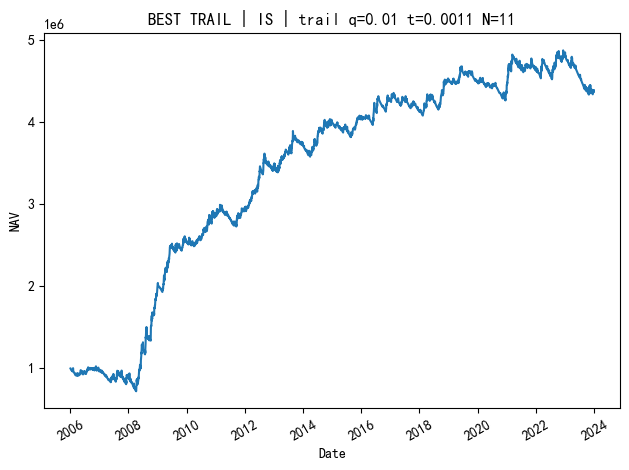

OOS: end_nav=1388145.50  max_dd=-0.109  trades=162  years=1.96  ann(CAGR)=18.18%


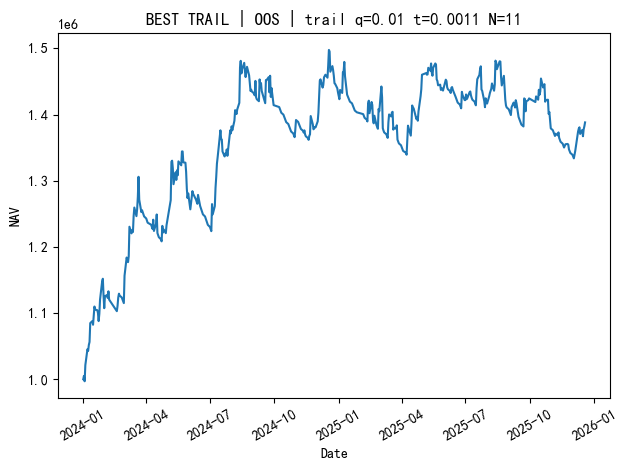

In [35]:
#  跟随信号
print("follow")

#   回测执行
df, grid, top = run_event_driven_full(
     Factor2,
    split_ts="2024-01-01",
     rank_by="end_nav",      # or "calmar_like" / "score" / "cagr"
     topk=20,
     plot_best=True
 )
